# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul
!pip install scikit-learn

In [1]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

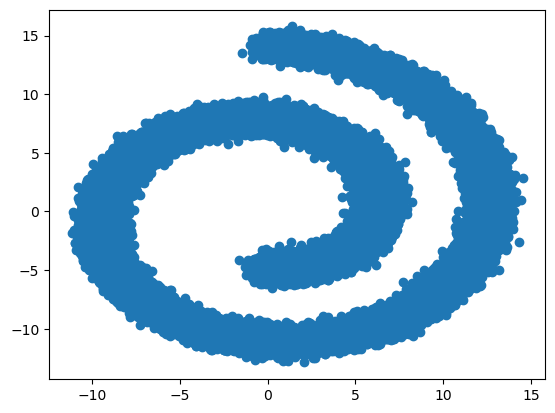

In [3]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

为了代码简洁性，我们将训练一个连续时间版本的扩散模型。实际上，离散时间和连续时间扩散模型的训练目标和代码是相似的。

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

给定数据样本 $x$ 和神经网络 $f_\theta(x, t)$，请按以下步骤实现扩散训练：

1. **采样扩散时间步**  
   $t \sim \text{Uniform}(0, 1)$

2. **计算噪声强度（余弦调度）**  
   $\alpha_t = \cos\left(\frac{\pi}{2}t\right)$  
   $\sigma_t = \sin\left(\frac{\pi}{2}t\right)$

3. **应用前向过程**  
   - 采样噪声 $\epsilon \sim \mathcal{N}(0, I)$（与 $x$ 同形状）
   - 计算加噪数据：$x_t = \alpha_t x + \sigma_t \epsilon$

4. **噪声估计**  
   $\hat{\epsilon} = f_\theta(x_t, t)$

5. **优化损失函数**  
   计算 MSE 损失：$L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$  
   （对所有维度取均值即可）

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

需要注意的是，在连续时间扩散模型中：
- 前向过程为 $x_{0\to1}$
- 反向过程为 $x_{1\to0}$

使用MLP（多层感知机）构建 $f_\theta$ 来优化损失函数。以下实现细节可能对你有帮助：
* **数据归一化**：使用训练数据集计算的均值和标准差进行归一化
* **训练配置**：
  - 训练100个epoch
  - 批大小1024
  - 使用Adam优化器（初始学习率1e-3）
  - 学习率调度：100步warmup后采用余弦衰减至0
* **网络结构**：
  - 4层隐藏层的MLP
  - 隐藏层维度64
* **时间条件注入**：将1维时间t与2维输入x拼接形成3维输入（即concat(x, t)）

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$

要实现标准的DDPM（去噪扩散概率模型）采样器，可以参考[DDIM论文](https://arxiv.org/pdf/2010.02502.pdf)中的方程。为方便起见，此处将该方程重新书写并格式化如下：

$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$

其中，$\epsilon_t \sim N(0, I)$ 是随机高斯噪声。对于DDPM，令  
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$

To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.

运行反向过程时，从 $x_1 \sim N(0, I)$ 开始，并执行 `num_steps` 次DDPM更新（这是一个超参数），伪代码如下：

```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

注意：如果遇到数值NaN（非数字）的情况，可能需要将 $\sigma_{t-1}^2 - \eta_t^2$ 的结果裁剪（clip）到 0，当其值为负数时。  
由于机器精度问题，当该值非常接近于 0 时（例如 -1e-12），可能会出现极小的负数。


In [2]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers):
        super(MLP, self).__init__()
        layers = []

        for i in range(num_hidden_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_size, 2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [5]:
def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """
    # 检查 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 数据预处理
    train_mean = np.mean(train_data, axis=0)
    train_std = np.std(train_data, axis=0)
    train_data = (train_data - train_mean) / train_std
    test_data = (test_data - train_mean) / train_std

    train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32))
    test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

    # 初始化模型
    model = MLP(input_size=3, hidden_size=64, num_hidden_layers=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    total_steps = 100 * len(train_loader)
    warmup_steps = 100

    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        else:
            progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    num_epochs = 100
    train_losses = []
    test_losses = []

    # test epoch 0
    model.eval()
    with torch.no_grad():
        total_test_loss = 0
        for batch in test_loader:
            x = batch[0].to(device)
            t = torch.rand(x.shape[0], 1).to(device)

            alpha_t = torch.cos(t * np.pi / 2)
            sigma_t = torch.sin(t * np.pi / 2)
            eps = torch.randn_like(x).to(device)
            x_t = alpha_t * x + sigma_t * eps

            input_x = torch.cat([x_t, t], dim=1)
            eps_hat = model(input_x)
            loss = F.mse_loss(eps_hat, eps)
            total_test_loss += loss.item()
            
        test_losses.append(total_test_loss / len(test_loader))
        print(f"Epoch {0}/{num_epochs}, Test Loss: {test_losses[-1]}")

    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            t = torch.rand(x.shape[0], 1).to(device)

            alpha_t = torch.cos(t * np.pi / 2)
            sigma_t = torch.sin(t * np.pi / 2)
            eps = torch.randn_like(x).to(device)
            x_t = alpha_t * x + sigma_t * eps

            input_x = torch.cat([x_t, t], dim=1)
            eps_hat = model(input_x)
            loss = F.mse_loss(eps_hat, eps)
            total_train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_losses.append(loss.item())
        
        # 每个 epoch 结束后计算测试损失
        model.eval()
        with torch.no_grad():
            total_test_loss = 0
            for batch in test_loader:
                x = batch[0].to(device)
                t = torch.rand(x.shape[0], 1).to(device)

                alpha_t = torch.cos(t * np.pi / 2)
                sigma_t = torch.sin(t * np.pi / 2)
                eps = torch.randn_like(x).to(device)
                x_t = alpha_t * x + sigma_t * eps

                input_x = torch.cat([x_t, t], dim=1)
                eps_hat = model(input_x)
                loss = F.mse_loss(eps_hat, eps)
                total_test_loss += loss.item()
                
            test_losses.append(total_test_loss / len(test_loader))
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_train_loss / len(train_loader)}, Test Loss: {test_losses[-1]}")

    # 采样
    all_samples = []
    num_steps_list = [1, 2, 4, 8, 16, 32, 64, 128, 256]

    for num_steps in num_steps_list:
        x = torch.randn(2000, 2).to(device)
        ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)

        with torch.no_grad():
            for i in range(num_steps):
                t = torch.full((2000, 1), ts[i], dtype=torch.float32).to(device)
                tm1 = torch.full((2000, 1), ts[i + 1], dtype=torch.float32).to(device)

                alpha_t = torch.cos(t * np.pi / 2)
                alpha_tm1 = torch.cos(tm1 * np.pi / 2)
                sigma_t = torch.sin(t * np.pi / 2)
                sigma_tm1 = torch.sin(tm1 * np.pi / 2)

                input_x = torch.cat([x, t], dim=1)
                eps_hat = model(input_x)
                eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - alpha_t ** 2 / alpha_tm1 ** 2)
                t1 = alpha_tm1 * ((x - sigma_t * eps_hat) / alpha_t)
                t2 = torch.sqrt(torch.clamp(sigma_tm1 ** 2 - eta_t ** 2, min=0)) * eps_hat
                # if i < num_steps - 1:
                #     eps_t = torch.randn_like(x)
                #     t3 = eta_t * eps_t
                # else:
                #     t3 = torch.zeros_like(x)
                eps_t = torch.randn_like(x)
                t3 = eta_t * eps_t
                x = t1 + t2 + t3

            all_samples.append(x.cpu().numpy())

    return np.array(train_losses), np.array(test_losses), np.array(all_samples)

Using device: cuda
Epoch 0/100, Test Loss: 1.0132942259311677
Epoch 1/100, Train Loss: 0.8047760220206513, Test Loss: 0.5629032909870147
Epoch 2/100, Train Loss: 0.5070245965402953, Test Loss: 0.4854835271835327
Epoch 3/100, Train Loss: 0.4738117283096119, Test Loss: 0.4711644142866135
Epoch 4/100, Train Loss: 0.46786624953454853, Test Loss: 0.4750735104084015
Epoch 5/100, Train Loss: 0.46135834771759654, Test Loss: 0.4562501072883606
Epoch 6/100, Train Loss: 0.4635868017770806, Test Loss: 0.46228426694869995
Epoch 7/100, Train Loss: 0.4624493578258826, Test Loss: 0.4417421638965607
Epoch 8/100, Train Loss: 0.45423795708588194, Test Loss: 0.452764955163002
Epoch 9/100, Train Loss: 0.4543321302958897, Test Loss: 0.4550990492105484
Epoch 10/100, Train Loss: 0.45449440789466, Test Loss: 0.45233563184738157
Epoch 11/100, Train Loss: 0.44996429523643183, Test Loss: 0.4440435439348221
Epoch 12/100, Train Loss: 0.4486715863553845, Test Loss: 0.4566820919513702
Epoch 13/100, Train Loss: 0.4471

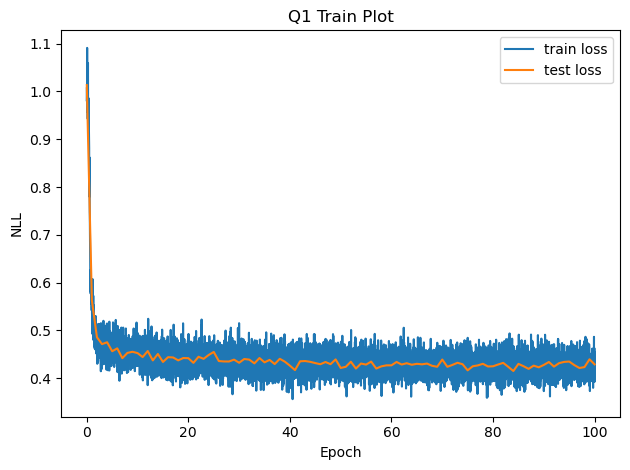

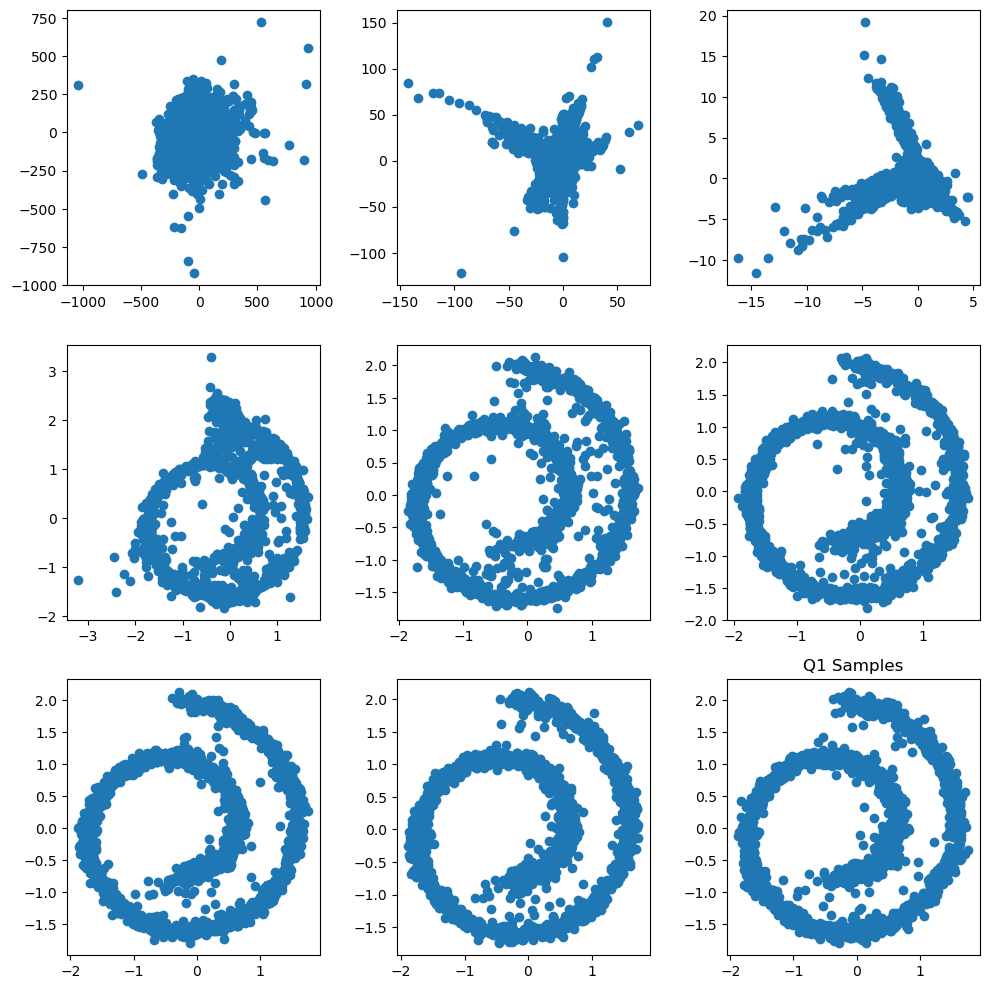

In [6]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


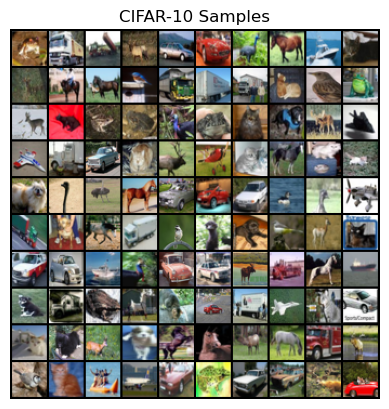

In [3]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:

```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.




**超参数细节**  
- **数据归一化**：将输入数据归一化到 `[-1, 1]` 范围  
- **UNet架构**：  
  - 隐藏层维度：`[64, 128, 256, 512]`  
  - 每维度残差块数：`2 blocks_per_dim`  
- **训练配置**：  
  - 训练轮次：`60 epochs`  
  - 批量大小：`256`  
  - 优化器：`Adam`（初始学习率 `1e-3`）  
  - 学习率调度：`100步warmup`后按`余弦衰减`至`0`  
- **扩散过程**：噪声调度、采样和损失函数设置与`Q1`保持一致  

**采样技巧**  
在每一步采样时，对生成值进行裁剪：  
$$
\hat{x} = \text{clip}\left(\frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t},\ -1,\ 1\right)
$$

In [1]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
from model.Unet import UNet

def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """
    # 检查 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 数据预处理
    train_data = 2 * train_data - 1
    test_data = 2 * test_data - 1
    
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32))
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    
    # 初始化模型
    model = UNet(3, [64, 128, 256, 512], 2).to(device)
    
    try:
        model.load_state_dict(torch.load(r'model\Unet_model.pth'))
        print("模型权重加载成功！")
    except FileNotFoundError:
        print("未找到权重文件，请检查文件路径。")
    except RuntimeError as e:
        print(f"加载权重时出现错误: {e}")
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    total_steps = 60 * len(test_loader)
    warmup_steps = 100

    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        else:
            progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))

    scheduler = LambdaLR(optimizer, lr_lambda)

    num_epochs = 0
    train_losses = []
    test_losses = []
    best_loss = float('inf')  # 初始化最佳损失为正无穷
    log_file_path = "q2_log.txt"  # 定义日志文件路径

    # test epoch 0
    model.eval()
    with torch.no_grad():
        total_test_loss = 0
        for batch in test_loader:
            x = batch[0].to(device)
            t = torch.rand(x.shape[0], 1, 1, 1).to(device)

            alpha_t = torch.cos(t * np.pi / 2)
            sigma_t = torch.sin(t * np.pi / 2)
            eps = torch.randn_like(x).to(device)
            x_t = alpha_t * x + sigma_t * eps

            eps_hat = model(x_t, t)
            loss = F.mse_loss(eps_hat, eps)
            total_test_loss += loss.item()
            
        test_losses.append(total_test_loss / len(test_loader))
        # 写入日志
        log_message = f"Epoch {0}/{num_epochs}, Test Loss: {test_losses[-1]}\n"
        with open(log_file_path, 'a') as file:  
            file.write(log_message)
        print(log_message.strip())
            

    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        # 生成进度条
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}')
        for batch_idx, batch in progress_bar:
            x = batch[0].to(device)
            t = torch.rand(x.shape[0], 1, 1, 1).to(device)

            alpha_t = torch.cos(t * np.pi / 2)
            sigma_t = torch.sin(t * np.pi / 2)
            eps = torch.randn_like(x).to(device)
            x_t = alpha_t * x + sigma_t * eps

            eps_hat = model(x_t, t)
            loss = F.mse_loss(eps_hat, eps)
            total_train_loss += loss.item()
            train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            avg_loss = total_train_loss / (batch_idx + 1)
            progress_bar.set_postfix({'Loss': f'{avg_loss:.4f}'})

        # 关闭进度条
        progress_bar.close()
        

        # 计算每个 epoch 结束后的测试损失
        model.eval()
        # 生成进度条
        test_progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc=f'Test Epoch {epoch + 1}')
        with torch.no_grad():
            total_test_loss = 0
            for batch_idx, batch in test_progress_bar:
                x = batch[0].to(device)
                t = torch.rand(x.shape[0], 1, 1, 1).to(device)

                alpha_t = torch.cos(t * np.pi / 2)
                sigma_t = torch.sin(t * np.pi / 2)
                eps = torch.randn_like(x).to(device)
                x_t = alpha_t * x + sigma_t * eps

                eps_hat = model(x_t, t)
                loss = F.mse_loss(eps_hat, eps)
                total_test_loss += loss.item()
                
            # 关闭进度条
            test_progress_bar.close()    
            test_losses.append(total_test_loss / len(test_loader))

            # 写入日志
            log_message = f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_train_loss / len(train_loader)}, Test Loss: {test_losses[-1]}\n"
            with open(log_file_path, 'a') as file:  
                file.write(log_message)
            print(log_message.strip())
            
            # 保存最佳模型
            if test_losses[-1] < best_loss:
                best_loss = test_losses[-1]
                torch.save(model.state_dict(), 'Unet_model.pth')
                print(f"save best model in epoch {epoch + 1}")


    # 采样
    all_samples = []
    num_steps_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

    for num_steps in num_steps_list:
        x = torch.randn(10, 3, 32, 32).to(device)
        ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)
 
        with torch.no_grad():
            for i in range(num_steps):
                t = torch.full((10, 1, 1, 1), ts[i], dtype=torch.float32).to(device)
                tm1 = torch.full((10, 1, 1, 1), ts[i + 1], dtype=torch.float32).to(device)

                alpha_t = torch.cos(t * np.pi / 2)
                alpha_tm1 = torch.cos(tm1 * np.pi / 2)
                sigma_t = torch.sin(t * np.pi / 2)
                sigma_tm1 = torch.sin(tm1 * np.pi / 2)

                eps_hat = model(x, t)
    
                # 裁剪
                x_hat = torch.clamp((x - sigma_t * eps_hat) / alpha_t, -1, 1)
                
                eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - alpha_t ** 2 / alpha_tm1 ** 2)
                t1 = alpha_tm1 * x_hat
                t2 = torch.sqrt(torch.clamp(sigma_tm1 ** 2 - eta_t ** 2, min=0)) * eps_hat
                # if i < num_steps - 1:
                #     eps_t = torch.randn_like(x)
                #     t3 = eta_t * eps_t
                # else:
                #     t3 = torch.zeros_like(x)
                eps_t = torch.randn_like(x)
                t3 = eta_t * eps_t
                x = t1 + t2 + t3
        
        all_samples.append(x.cpu().numpy())

    all_samples = np.array(all_samples)
    all_samples = (all_samples + 1) / 2
    all_samples = np.transpose(all_samples, (0, 1, 3, 4, 2))

    return np.array(train_losses), np.array(test_losses), all_samples

Files already downloaded and verified
Files already downloaded and verified
Using device: cuda
模型权重加载成功！
Epoch 0/0, Test Loss: 0.06604578327387571
Final Test Loss: 0.0660


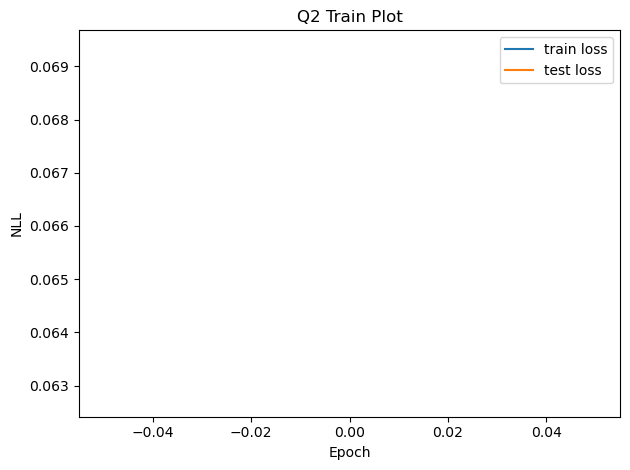

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00029045343..1.0003238].


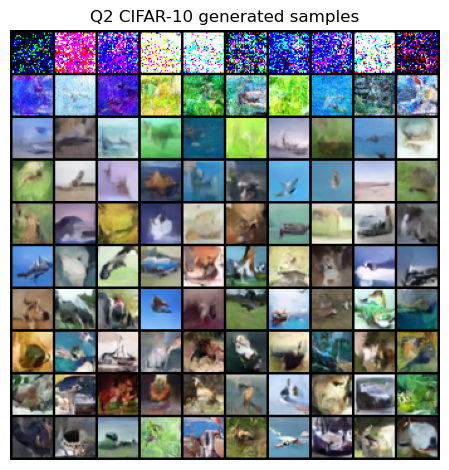

In [3]:
q2_save_results(q2)

# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

In [1]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

Files already downloaded and verified
Files already downloaded and verified


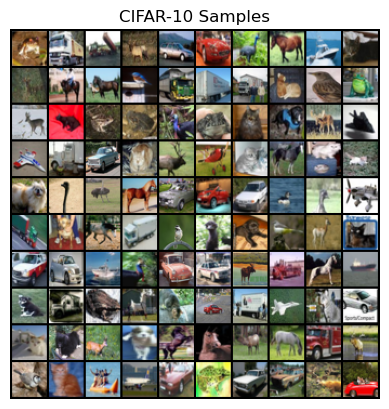

Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


In [2]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.


In [ ]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""

# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1

#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]

#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """

# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.

#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.

#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """


In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

在本部分中，您需要：

1. **图像重建可视化**
   - 将给定的图像输入VAE模型
   - 计算并可视化重建后的图像结果

2. **缩放因子计算**
   - 为了后续扩散模型的训练数据标准化，需要计算一个缩放因子
   - 具体步骤：
     1. 将1000张图像编码到VAE的潜在空间中
     2. 将所有维度的张量展平(flatten)成一维向量
     3. 计算这些数据的标准差(standard deviation)作为缩放因子

这个缩放因子将用于扩散模型训练时的数据标准化处理。

In [ ]:
import numpy as np
import torch

def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """
  
    image = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2).cuda()

    # 编码
    latent_space = vae.encode(image)

    # 计算缩放因子
    scale_factor = np.std(latent_space.detach().cpu().numpy().flatten())

    # 解码
    reimages = vae.decode(latent_space)
    
    reimages = reimages.detach().cpu().permute(0, 2, 3, 1).numpy()
    selected_images = np.stack([images[:50], reimages[:50]], axis=1)

    return selected_images, scale_factor

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.242949..1.0].


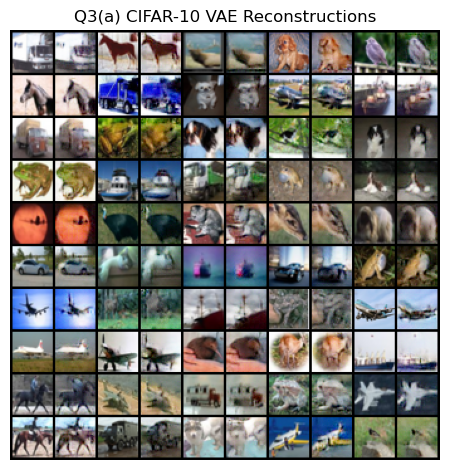

Scale factor: 1.0433


In [11]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]

In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.

```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

## 超参数细节

### 数据处理流程
1. 将图像归一化到[-1, 1]范围
2. 使用VAE进行编码
3. 将潜在向量除以在(a)部分计算得到的`scale_factor`

### 模型架构
- **Transformer配置**：
  - 补丁大小(patch_size): 2
  - 隐藏层维度(hidden_size): 512
  - 注意力头数(num_heads): 8
  - 层数(num_layers): 12

### 训练设置
- 训练60个epoch
- 批量大小(batch_size): 256
- 优化器: Adam (学习率1e-3)
  - 100步warmup
  - 余弦衰减至0

### 采样注意事项
- 生成潜在向量后，**必须**先乘以`scale_factor`再输入解码器

### 扩散设置
- 扩散计划表、采样过程和损失函数与Q1保持一致

### 类别条件处理
1. 为每个类别学习一个嵌入向量
2. 额外学习一个"空类别"的嵌入向量
3. 条件注入方式：将类别嵌入与时间步嵌入相加后输入Transformer块
   - **重要**：训练时10%的概率丢弃类别条件（替换为"空类别"），这在(c)部分会用到

> **模型保存提醒**：训练完成后请保存模型参数，(c)部分将会需要使用

In [3]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from model.DIT import DiT


def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """

    # 检查 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # 数据预处理
    train_data = 2 * train_data - 1
    test_data = 2 * test_data - 1
    
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    # 初始化模型
    model = DiT(input_shape=(4, 8, 8), patch_size=2, hidden_size=512, num_heads=8, num_layers=12, num_classes=10, cfg_dropout_prob=0.1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    total_steps = 60 * len(train_loader)
    warmup_steps = 100

    try:
        model.load_state_dict(torch.load(r'model\Dit2_model.pth'))
        print("模型权重加载成功！")
    except FileNotFoundError:
        print("未找到权重文件，请检查文件路径。")
    except RuntimeError as e:
        print(f"加载权重时出现错误: {e}")
    
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        else:
            progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    num_epochs = 0
    train_losses = []
    test_losses = []
    best_loss = float('inf')  # 初始化最佳损失为正无穷
    log_file_path = "q3_b_2_log.txt"  # 定义日志文件路径

    # test epoch 0
    model.eval()
    with torch.no_grad():
        total_test_loss = 0
        for batch in test_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            # 编码
            x = vae.encode(x)
            # scale_factor = 1.046503
            scale_factor = 1.04
            x = x / scale_factor

            t = torch.rand(x.shape[0], 1).to(device)
            alpha_t = torch.cos(t * np.pi / 2).unsqueeze(2).unsqueeze(3)
            sigma_t = torch.sin(t * np.pi / 2).unsqueeze(2).unsqueeze(3)
            eps = torch.randn_like(x).to(device)
            x_t = alpha_t * x + sigma_t * eps

            eps_hat = model(x_t, y, t)
            loss = F.mse_loss(eps_hat, eps)
            total_test_loss += loss.item()
            
        test_losses.append(total_test_loss / len(test_loader))
        # 写入日志
        log_message = f"Epoch {0}/{num_epochs}, Test Loss: {test_losses[-1]}\n"
        with open(log_file_path, 'a') as file:  
            file.write(log_message)
        print(log_message.strip())
    
    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        # 生成进度条
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Train Epoch {epoch + 1}/{num_epochs}')
        for batch_idx, batch in progress_bar:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            # 编码
            x = vae.encode(x)
            # scale_factor = 1.046503
            scale_factor = 1.04
            x = x / scale_factor

            t = torch.rand(x.shape[0], 1).to(device)
            alpha_t = torch.cos(t * np.pi / 2).unsqueeze(2).unsqueeze(3)
            sigma_t = torch.sin(t * np.pi / 2).unsqueeze(2).unsqueeze(3)
            eps = torch.randn_like(x).to(device)
            x_t = alpha_t * x + sigma_t * eps

            eps_hat = model(x_t, y, t)
            loss = F.mse_loss(eps_hat, eps)
            total_train_loss += loss.item()
            train_losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # 更新进度条
            avg_loss = total_train_loss / (batch_idx + 1)
            progress_bar.set_postfix({'Loss': f'{avg_loss:.4f}'})

        # 关闭进度条
        progress_bar.close()

        # 计算每个 epoch 结束后的测试损失
        model.eval()
        test_progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc=f'Test Epoch {epoch + 1}')
        with torch.no_grad():
            total_test_loss = 0
            for batch_idx, batch in test_progress_bar:
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                
                # 编码
                x = vae.encode(x)
                # scale_factor = 1.046503
                scale_factor = 1.04
                x = x / scale_factor

                t = torch.rand(x.shape[0], 1).to(device)
                alpha_t = torch.cos(t * np.pi / 2).unsqueeze(2).unsqueeze(3)
                sigma_t = torch.sin(t * np.pi / 2).unsqueeze(2).unsqueeze(3)
                eps = torch.randn_like(x).to(device)
                x_t = alpha_t * x + sigma_t * eps

                eps_hat = model(x_t, y, t)
                loss = F.mse_loss(eps_hat, eps)
                total_test_loss += loss.item()
            
            # 关闭进度条
            test_progress_bar.close()    
            
            test_losses.append(total_test_loss / len(test_loader))
            # 写入日志
            log_message = f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_train_loss / len(train_loader)}, Test Loss: {test_losses[-1]}\n"
            with open(log_file_path, 'a') as file:  
                file.write(log_message)
            print(log_message.strip())
        
        # 保存最佳模型
        if test_losses[-1] < best_loss:
            best_loss = test_losses[-1]
            torch.save(model.state_dict(), 'Dit2_model.pth')
            print(f"save best model in epoch {epoch + 1}")
        

    # 采样
    print("start samples:")
    samples = []
    num_steps = 512
    for class_idx in range(10):
        print(f"generate class {class_idx}")

        x = torch.randn(10, 4, 8, 8).to(device)
        y = torch.tensor([class_idx], dtype=torch.long).repeat(10).to(device)
        ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)

        with torch.no_grad():
            for i in range(num_steps):
                t = torch.full((10, 1), ts[i], dtype=torch.float32).to(device)
                tm1 = torch.full((10, 1), ts[i + 1], dtype=torch.float32).to(device)

                alpha_t = torch.cos(t * np.pi / 2).unsqueeze(2).unsqueeze(3)
                alpha_tm1 = torch.cos(tm1 * np.pi / 2).unsqueeze(2).unsqueeze(3)
                sigma_t = torch.sin(t * np.pi / 2).unsqueeze(2).unsqueeze(3)
                sigma_tm1 = torch.sin(tm1 * np.pi / 2).unsqueeze(2).unsqueeze(3)

                eps_hat = model(x, y, t)
                
                # 裁剪
                # x_hat = torch.clamp((x - sigma_t * eps_hat) / alpha_t, -1, 1)
                
                eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - alpha_t ** 2 / alpha_tm1 ** 2)
                # t1 = alpha_tm1 * x_hat
                t1 = alpha_tm1 * ((x - sigma_t * eps_hat) / alpha_t)
                t2 = torch.sqrt(torch.clamp(sigma_tm1 ** 2 - eta_t ** 2, min=0)) * eps_hat
                eps_t = torch.randn_like(x)
                t3 = eta_t * eps_t
                x = t1 + t2 + t3

        # scale_factor = np.std(x.detach().cpu().numpy().flatten())
        # print(scale_factor)
        # scale_factor = 1.046503
        # 解码
        scale_factor = 1.04
        x = x * scale_factor
        x = vae.decode(x)
        samples.append(x.cpu().numpy())
        
    
    samples = np.array(samples)
    samples = np.transpose(samples, (0, 1, 3, 4, 2))
    samples = (samples + 1) / 2

    return np.array(train_losses), np.array(test_losses), samples

Files already downloaded and verified
Files already downloaded and verified
Using device: cuda
模型权重加载成功！
Epoch 0/0, Test Loss: 0.41526656597852707
start samples:
generate class 0
generate class 1
generate class 2
generate class 3
generate class 4
generate class 5
generate class 6
generate class 7
generate class 8
generate class 9
Final Test Loss: 0.4153


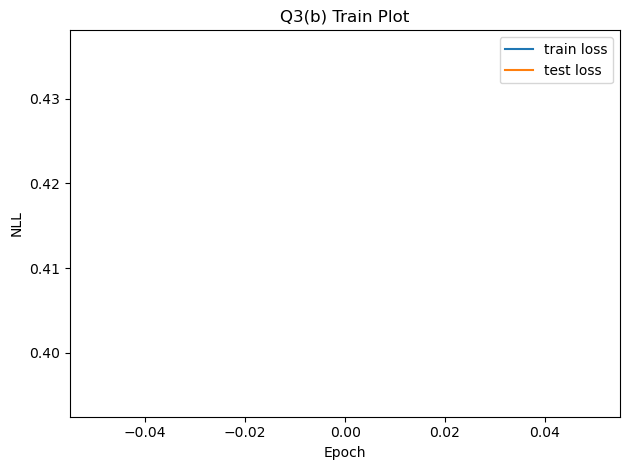

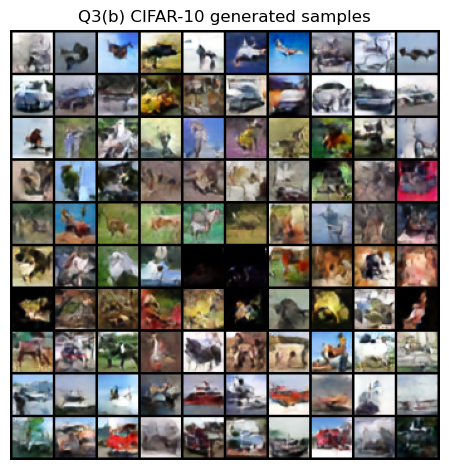

In [14]:
q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

在本部分中，您将实现[无分类器引导](https://arxiv.org/abs/2207.12598)(Classifier-Free Guidance, CFG)。CFG是扩散模型采样过程中广泛使用的方法，旨在使生成样本更准确地与条件信息（如类别、文本描述）对齐。

实现CFG需要对扩散采样代码进行小幅修改。给定CIFAR-10类别标签后，不再使用$\hat{\epsilon} = f_\theta(x_t, t, y)$进行采样，而是改用：
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
其中$w$是控制CFG强度的采样超参数。$\varnothing$表示丢弃类别标签的无条件模型，您已在3(b)部分预训练的UNet应支持此功能。注意当$w = 1$时将恢复标准采样。

说明：当CFG值设置过高时，可能会出现生成质量下降的情况（如图像过饱和）。生成质量随CFG值增加通常呈U型曲线（先提升后下降）。

In [ ]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import torch
from model.DIT import DiT


def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """
    # 检查 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 初始化 GPU
    model = DiT(input_shape=(4, 8, 8), patch_size=2, hidden_size=512, num_heads=8, num_layers=12, num_classes=10, cfg_dropout_prob=0.1).to(device)
    
    try:
        model.load_state_dict(torch.load(r'model\Dit2_model.pth'))
        print("模型权重加载成功！")
    except FileNotFoundError:
        print("未找到权重文件，请检查文件路径。")
    except RuntimeError as e:
        print(f"加载权重时出现错误: {e}")

    # 存储不同 CFG 值的采样结果
    all_samples = []
    cfg_values = [1.0, 3.0, 5.0, 7.5]
    num_steps = 512

    for cfg in cfg_values:
        class_samples = []
        for class_idx in range(10):
            print(f"class {class_idx}, cfg: {cfg}")

            x = torch.randn(10, 4, 8, 8).to(device)
            y = torch.tensor([class_idx], dtype=torch.long).repeat(10).to(device)
            y_non = torch.tensor([10], dtype=torch.long).repeat(10).to(device)  # 无条件模型的类别标签
            ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)

            with torch.no_grad():
                for i in range(num_steps):
                    t = torch.full((10, 1), ts[i], dtype=torch.float32).to(device)
                    tm1 = torch.full((10, 1), ts[i + 1], dtype=torch.float32).to(device)

                    alpha_t = torch.cos(t * np.pi / 2).unsqueeze(2).unsqueeze(3)
                    alpha_tm1 = torch.cos(tm1 * np.pi / 2).unsqueeze(2).unsqueeze(3)
                    sigma_t = torch.sin(t * np.pi / 2).unsqueeze(2).unsqueeze(3)
                    sigma_tm1 = torch.sin(tm1 * np.pi / 2).unsqueeze(2).unsqueeze(3)

                    # 无条件预测
                    eps_hat_non = model(x, y_non, t)
                    # 有条件预测
                    eps_hat = model(x, y, t)

                    # CFG 公式
                    eps_hat = eps_hat_non + cfg * (eps_hat - eps_hat_non)

                    eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - alpha_t ** 2 / alpha_tm1 ** 2)
                    t1 = alpha_tm1 * ((x - sigma_t * eps_hat) / alpha_t)
                    t2 = torch.sqrt(torch.clamp(sigma_tm1 ** 2 - eta_t ** 2, min=0)) * eps_hat
                    eps_t = torch.randn_like(x)
                    t3 = eta_t * eps_t
                    x = t1 + t2 + t3

            scale_factor = 1.04
            x = x * scale_factor
            x = vae.decode(x)
            class_samples.append(x.cpu().numpy())

        class_samples = np.array(class_samples)
        class_samples = np.transpose(class_samples, (0, 1, 3, 4, 2))
        class_samples = (class_samples + 1) / 2
        
        all_samples.append(class_samples)

    all_samples = np.array(all_samples)
    return all_samples

In [ ]:
q3c_save_results(q3_c)